In [2]:
import pandas as pd
import numpy as np
import os
import requests

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [3]:
# Downloads the updated csv for the 2023 season
import gdown

def update_df():
    '''
    Download most recent csv file, concat with rest of data, return the full df
    '''
    output = "lol_2023.csv" #What to save the downloaded file as
    id = "1XXk2LO0CsNADBB1LRGOV5rUpyZdEZ8s2" #The id from the google drive file
    gdown.download(id=id, output=output, quiet=False)
    
    df_2021 = pd.read_csv('lol_2021.csv')
    df_2022 = pd.read_csv('lol_2022.csv')
    df_2023 = pd.read_csv('lol_2023.csv')
    df = pd.concat([df_2021,df_2022,df_2023])
    return df

def get_wiki():
    '''
    Returns chart from wikipedia containing info for Tier 1 and Tier 2 leagues
    Returns tier1, tier2
    '''
    wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_League_of_Legends_leagues_and_tournaments')
    return wiki[1], wiki[3]

def wrangle_df(df):
    leagues = ['LCK','LPL','LEC','LCS','PCS','VCS','CBLOL','LJL','LLA'] # These are my 9 tier 1 leagues that I'll keep
    
    df = df[df.league.isin(leagues)]
    df = df[df.position=='team']

    cols = ['teamname','league', 'date', 'side', 'gamelength','game', 'result', 'teamkills', 
            'teamdeaths', 'firstblood', 'position', 'dragons', 'barons', 'opp_barons','towers', 'opp_towers', 
            'inhibitors', 'opp_inhibitors', 'damagetochampions', 'damagetakenperminute', 'wardsplaced', 'wardskilled', 
            'controlwardsbought', 'totalgold', 'gspd']

    df = df[cols]
    df = df.dropna()
    
    df.date = pd.to_datetime(df.date,infer_datetime_format=True)
    del df['position']
    df = df.sort_values('date')
    df = df.reset_index(drop=True)
    df.side = np.where(df.side=='Blue',1,0)
    df.rename(columns={'side':'blue_side'},inplace = True)
    
    df.to_csv('final.csv')
    
    return df

def get_train(df):
    train_len = int(df.shape[0]*.6)
    train = df.iloc[:train_len]
    return train
    

In [4]:
df = update_df()
df.to_csv('raw.csv')
df = wrangle_df(df)
df.to_csv('final.csv')

Downloading...
From: https://drive.google.com/uc?id=1XXk2LO0CsNADBB1LRGOV5rUpyZdEZ8s2
To: /Users/thegootch/codeup-data-science/league/lol_2023.csv
100%|██████████████████████████████████████| 31.0M/31.0M [00:02<00:00, 10.4MB/s]
/var/folders/fz/0282wvb93rn0lm_p0nscw1sm0000gn/T/ipykernel_1518/3270662144.py:1: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  df = update_df()


In [5]:
df = pd.read_csv('final.csv',index_col=0)
raw = pd.read_csv('raw.csv',index_col=0)

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3442: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
def win_percent(elo_a,elo_b): #Calculate odds to win based off of elo rankings
    return 1/(1+10**((elo_b-elo_a)/400)) #elo_a is who you're calculating for, elo_b is opponent

def win_prob(x): # x is the American odds (-110,110,etc.) Calculates probably of winning
    if x < 0 :
        x = x*-1
        return x / (x + 100)
    else: 
        return 100 / (x + 100)

def gain_elo(elo,opp_elo,k=32): #Gain elo after a win, k=24, expected = 1
    return int(elo+k*(1-win_percent(elo,opp_elo)))

def lose_elo(elo,opp_elo,k=32): #Lose elo after a loss, k=24, expected = 0
    return int(elo+k*(0-win_percent(elo,opp_elo)))

def tie_elo(elo,opp_elo,k=32): #Lose elo after a loss, k=24, expected = .5
    return int(elo+k*(.5-win_percent(elo,opp_elo)))



In [7]:
df['old_elo']=np.NaN #create new elo column
df['new_elo']=np.NaN
df['opp_elo']=np.NaN
df.loc[df[~df.teamname.duplicated()].index,'old_elo']=1200 #set elo for first game to 1200 for each team

In [8]:
def add_opp_name(df): #tup = list of tuples
    # Create an 'opp_name' column for each row
    evens = range(0,df.shape[0],2)
    odds = range(1,df.shape[0],2)
    tup = [(a,b) for a,b in zip(evens,odds)] # list of tuples
    
    for t in tup: #iterate through list of tuples
        a,b= t #unpack each tuple into two values
        df.loc[a,'opp_name']=df.teamname.loc[b] #create new column w/opp_name
        df.loc[b,'opp_name']=df.teamname.loc[a]
        
    return df

df = add_opp_name(df) #adds opponents' name

In [9]:
for i in range(0,df.shape[0]):
    opp_name = df.loc[i,'opp_name']
    df.loc[i,'opp_elo'] = df[(df.teamname==opp_name)&(~df.old_elo.isna())]['old_elo'].iloc[-1]
    if df.loc[i,'result'] == 1:
        df.loc[i,'new_elo'] = gain_elo(df.loc[i,'old_elo'],df.loc[i,'opp_elo'])
    else:
        df.loc[i,'new_elo'] = lose_elo(df.loc[i,'old_elo'],df.loc[i,'opp_elo'])
        
    team_name = df.loc[i,'teamname']
    try:
        next_game_index = df[(df.teamname==team_name)&df.old_elo.isna()]['old_elo'].index[0]
        df.loc[next_game_index,'old_elo'] = df[(df.teamname==team_name)&(~df.new_elo.isna())]['new_elo'].iloc[-1]
    except:
        pass
    

In [10]:
current_elo = df[~df.teamname.duplicated(keep='last')][['teamname','league','opp_name','old_elo','opp_elo','new_elo']]

In [25]:
current_elo.head()

,teamname,league,opp_name,old_elo,opp_elo,new_elo
1995,Cruzeiro eSports,CBLOL,KaBuM! e-Sports,1116.0,1187.0,1135.0
2286,eStar,LPL,Suning,986.0,1268.0,980.0
4800,FC Schalke 04 Esports,LEC,Fnatic,1051.0,1189.0,1041.0
4926,Rogue Warriors,LPL,JD Gaming,1054.0,1145.0,1074.0
4963,Alpha Esports,PCS,Beyond Gaming,945.0,1342.0,942.0


In [114]:
def get_teams(df,teams,opponents,bet_odds): #returns df with 'home' and 'away' teams with elos and implied odds
    team_list = []
    for team, opponent,odds in zip(teams,opponents,bet_odds):
        row1 = df[df.teamname==team][['teamname','new_elo']]
        row1['odds'] = odds[0]
        row2 = df[df.teamname==opponent][['teamname','new_elo']]
        row2['odds'] = odds[1]
        row3 = pd.concat([row1,row2])
        row3.columns = ['teamname','elo','odds']
        row3['opponent'] = [row2.teamname.iloc[0],row1.teamname.iloc[0]]
        row3['next_opp_elo'] = [row2.new_elo.iloc[0],row1.new_elo.iloc[0]]
        team_list.append(row3)
    temp = pd.concat(team_list)
    temp = temp[['teamname','elo','opponent','next_opp_elo','odds']]
    temp['implied_odds'] = temp.odds.apply(win_prob)
    return temp.reset_index(drop=True)

In [130]:
home = ['Cloud9','eStar']
away = ['Bilibili Gaming','Rogue Warriors']
odds = [(-230,280),(160,-110)]
monies = get_teams(current_elo,home,away,odds)
monies['elo_odds'] = 0
for i in range(0,ok.shape[0]):
    monies.loc[i,'elo_odds'] = win_percent(monies.loc[i,'elo'],monies.loc[i,'next_opp_elo'])
monies['odds_diff'] = monies.elo_odds-ok.implied_odds
#monies.sort_values('odds_diff',ascending=False)

In [131]:
monies

,teamname,elo,opponent,next_opp_elo,odds,implied_odds,elo_odds,odds_diff
0,Cloud9,1368.0,Bilibili Gaming,1248.0,-230,0.696970,0.666139,0.066139
1,Bilibili Gaming,1248.0,Cloud9,1368.0,280,0.263158,0.333861,0.000527
2,eStar,980.0,Rogue Warriors,1074.0,160,0.384615,0.367930,-0.155880
3,Rogue Warriors,1074.0,eStar,980.0,-110,0.523810,0.632070,0.155880


In [120]:
ok

,teamname,elo,opponent,next_opp_elo,odds,implied_odds,elo_odds,odds_diff
0,Cloud9,1368.0,Bilibili Gaming,1248.0,-150,0.600000,0.666139,0.066139
1,Bilibili Gaming,1248.0,Cloud9,1368.0,200,0.333333,0.333861,0.000527
2,eStar,980.0,Rogue Warriors,1074.0,-110,0.523810,0.367930,-0.155880
3,Rogue Warriors,1074.0,eStar,980.0,110,0.476190,0.632070,0.155880


In [35]:
win_prob(180) #based on betting odds

0.35714285714285715

In [276]:
win_percent(1389,1262) #based on elo

0.6750402010402987

In [278]:
df.league.unique()

array(['LPL', 'LCK', 'LCS', 'CBLOL', 'VCS', 'LEC', 'LJL', 'LLA', 'PCS'],
      dtype=object)

In [282]:
df[df.teamname.str.contains('Bil')]

,teamname,league,date,blue_side,gamelength,game,result,teamkills,teamdeaths,firstblood,dragons,barons,opp_barons,towers,opp_towers,inhibitors,opp_inhibitors,damagetochampions,damagetakenperminute,wardsplaced,wardskilled,controlwardsbought,totalgold,gspd,old_elo,new_elo,opp_elo,opp_name
19,Bilibili Gaming,LPL,2021-01-11 09:16:37,0,2450,1.0,0,4,14,0.0,2.0,0.0,1.0,3.0,10.0,0.0,2.0,47594.0,2490.1224,120.0,92.0,46.0,66238,-0.088639,1200.0,1184.0,1216.0,eStar
21,Bilibili Gaming,LPL,2021-01-11 10:17:55,0,1620,2.0,1,18,6,1.0,4.0,1.0,0.0,10.0,2.0,2.0,0.0,51913.0,2433.2963,81.0,37.0,35.0,56117,0.196519,1184.0,1200.0,1198.0,eStar
23,Bilibili Gaming,LPL,2021-01-11 11:03:58,0,1960,3.0,1,19,11,1.0,2.0,2.0,0.0,11.0,3.0,5.0,0.0,66801.0,2197.1939,92.0,69.0,36.0,66909,0.117561,1200.0,1215.0,1182.0,eStar
59,Bilibili Gaming,LPL,2021-01-14 09:18:34,1,2645,1.0,0,21,25,1.0,3.0,2.0,1.0,5.0,10.0,1.0,2.0,139788.0,3535.0321,141.0,90.0,60.0,81021,0.015262,1215.0,1197.0,1188.0,JD Gaming
63,Bilibili Gaming,LPL,2021-01-14 10:22:42,0,1832,2.0,0,8,19,1.0,0.0,0.0,1.0,3.0,8.0,0.0,1.0,39206.0,2919.3668,90.0,43.0,41.0,49940,-0.083592,1197.0,1181.0,1204.0,JD Gaming
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,Bilibili Gaming,LPL,2023-04-11 13:07:17,1,1919,5.0,1,20,15,1.0,3.0,1.0,0.0,7.0,2.0,1.0,0.0,84194.0,2584.1271,103.0,45.0,37.0,60173,0.073962,1244.0,1260.0,1250.0,EDward Gaming
15048,Bilibili Gaming,LPL,2023-04-15 08:40:45,0,1656,1.0,0,9,18,1.0,1.0,0.0,1.0,4.0,10.0,0.0,2.0,45792.0,3361.3406,90.0,43.0,34.0,46499,-0.107019,1260.0,1249.0,1383.0,JD Gaming
15052,Bilibili Gaming,LPL,2023-04-15 09:33:07,1,1371,2.0,0,3,19,0.0,1.0,0.0,1.0,1.0,8.0,0.0,1.0,32318.0,2847.7024,63.0,30.0,25.0,37388,-0.113380,1249.0,1239.0,1393.0,JD Gaming
15058,Bilibili Gaming,LPL,2023-04-15 10:21:07,1,2061,3.0,1,19,8,1.0,3.0,3.0,0.0,9.0,4.0,2.0,0.0,77125.0,2373.8865,125.0,56.0,56.0,69424,0.115950,1239.0,1262.0,1402.0,JD Gaming


In [283]:
current_elo[(current_elo.teamname == 'Bilibili Gaming')|(current_elo.teamname == 'Movistar R7')].sort_values('new_elo',ascending=False).head(20)

,teamname,league,opp_name,old_elo,opp_elo,new_elo
15046,Movistar R7,LLA,Six Karma,1298.0,1261.0,1280.0
15065,Bilibili Gaming,LPL,JD Gaming,1262.0,1379.0,1251.0


In [1]:
df[df.teamname=='Cloud 9'][['teamname','opp_name','date','result','old_elo','opp_elo','new_elo']].head(50)

NameError: name 'df' is not defined

In [6]:
df = df.sort_values(['date','game'])

In [10]:
df.date.sort_values(ascending = False)

15111    2023-04-17 18:06:20
15110    2023-04-17 18:06:20
15109    2023-04-17 17:10:13
15108    2023-04-17 17:10:13
15107    2023-04-17 16:13:13
                ...         
5        2021-01-09 11:30:25
2        2021-01-09 10:16:20
3        2021-01-09 10:16:20
1        2021-01-09 09:22:04
0        2021-01-09 09:22:04
Name: date, Length: 15112, dtype: object

In [7]:
train = get_train(df)

In [8]:
numerical = train.select_dtypes(['int','float']).columns

<BarContainer object of 12862 artists>

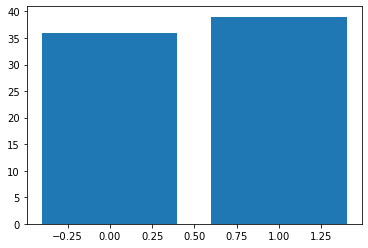

In [9]:
plt.bar(df.result,df.teamkills)

In [10]:
df.corr()['result'].sort_values() #Worth exploring gspd, barons, dragons, damagetochampions, firstblood, wardskilled

opp_towers             -8.928289e-01
opp_inhibitors         -7.616441e-01
teamdeaths             -7.040007e-01
opp_barons             -6.400607e-01
damagetakenperminute   -2.321933e-01
gamelength              4.882873e-17
game                    2.081712e-16
controlwardsbought      8.245991e-04
blue_side               4.587156e-02
wardsplaced             5.309540e-02
wardskilled             1.356691e-01
firstblood              2.327788e-01
damagetochampions       3.041868e-01
totalgold               4.408372e-01
dragons                 5.962158e-01
barons                  6.400607e-01
teamkills               7.050389e-01
gspd                    7.550345e-01
inhibitors              7.616441e-01
towers                  8.928289e-01
result                  1.000000e+00
Name: result, dtype: float64

In [11]:
def plot_cols(df):
    columns = ['blue_side', 'firstblood' ,'gspd', 'barons', 'dragons', 'damagetochampions','wardsplaced', 'wardskilled']

    plt.figure(figsize = (10,20))
    count = 1
    for col in columns:
        plt.subplot(4,2,count)
        plt.title(col)
        sns.barplot(data=df,x='result',y=col)
        count+=1
    plt.tight_layout()
    plt.show()

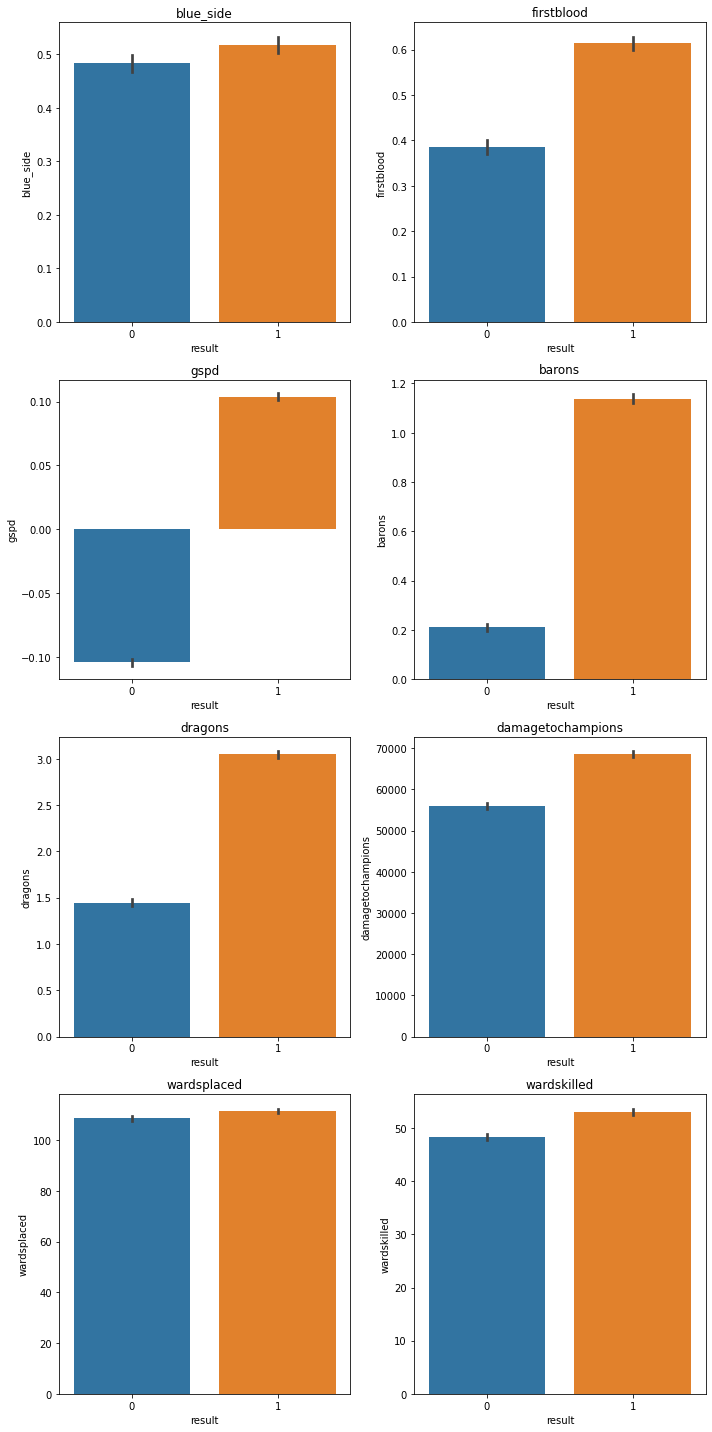

In [12]:
plot_cols(train)

In [13]:
columns = ['blue_side', 'firstblood' ,'gspd', 'barons', 'dragons', 'damagetochampions','wardsplaced', 'wardskilled']

In [14]:
from scipy.stats import ttest_ind

In [15]:
def get_tstat(train):  
    ind=0
    temp_list = []
    for col in columns:
        t,p= ttest_ind(train[col],train.result, equal_var=False)
        temp = pd.DataFrame({'column':col,'t_stat':t,'p_value':p},index=[ind])
        ind+=1
        temp_list.append(temp)
    tstat = pd.concat(temp_list)
    tstat.p_value = tstat.p_value.round(decimals=2)
    return tstat

In [16]:
tstat = get_tstat(train)
tstat

,column,t_stat,p_value
0,blue_side,0.016098,0.99
1,firstblood,-0.048293,0.96
2,gspd,-84.683710,0.00
3,barons,17.410022,0.00
4,dragons,104.401655,0.00
5,damagetochampions,257.475200,0.00
6,wardsplaced,319.204433,0.00
7,wardskilled,243.744289,0.00


In [17]:
t,p= ttest_ind(train.blue_side,train.result, equal_var=False)
print(f'T-Statistic:{round(t,2)}  P-Value:{round(p,2)}')

T-Statistic:0.02  P-Value:0.99


In [115]:
def create_target(groupby):
    groupby['target']=groupby['result'].shift(-1)
    return groupby

In [116]:
def add_target(df):
    df = df.groupby('teamname').apply(create_target)
    df.loc[pd.isnull(df.target),'target'] =2
    df.target = df.target.astype(int,errors='ignore')
    return df

In [117]:
df = add_target(df)

In [120]:
df.head()

,teamname,league,date,blue_side,gamelength,game,result,teamkills,teamdeaths,firstblood,dragons,barons,opp_barons,towers,opp_towers,inhibitors,opp_inhibitors,damagetochampions,damagetakenperminute,wardsplaced,wardskilled,controlwardsbought,totalgold,gspd,elo,target,opp_name
0,Top Esports,LPL,2021-01-09 09:22:04,1,2050,1.0,0,3,9,1.0,2.0,0.0,1.0,3.0,6.0,0.0,1.0,63315.0,2559.0146,101.0,83.0,40.0,54617,-0.000467,1200.0,0,Suning
1,Suning,LPL,2021-01-09 09:22:04,0,2050,1.0,1,9,3,0.0,2.0,1.0,0.0,6.0,3.0,1.0,0.0,58406.0,2940.4390,161.0,61.0,46.0,60520,0.000467,1200.0,1,Top Esports
2,Top Esports,LPL,2021-01-09 10:16:20,1,2241,2.0,0,16,27,0.0,3.0,2.0,0.0,6.0,7.0,0.0,2.0,84516.0,3790.4150,121.0,73.0,42.0,69692,-0.015474,NaN,1,Suning
3,Suning,LPL,2021-01-09 10:16:20,0,2241,2.0,1,27,17,1.0,2.0,0.0,2.0,7.0,6.0,2.0,0.0,97504.0,3192.6372,155.0,55.0,49.0,70269,0.015474,NaN,0,Top Esports
4,Oh My God,LPL,2021-01-09 11:30:25,1,1887,1.0,0,4,15,1.0,1.0,0.0,1.0,3.0,9.0,0.0,1.0,37351.0,2777.9332,104.0,47.0,32.0,51145,-0.028532,1200.0,1,EDward Gaming


In [23]:
from sklearn.preprocessing import MinMaxScaler #scale all numerical columns

removed_columns = ['teamname','league','date','target','opp_name']
selected_columns = df.columns[~df.columns.isin(removed_columns)]

scaler = MinMaxScaler()
df[selected_columns] = scaler.fit_transform(df[selected_columns])


In [121]:
# Create rolling averages for columns, concat as new columns to df


def rolling(team):
    rolling = team.rolling(10).mean()
    return rolling

def add_rolling(df):
    cols = ['gamelength','teamkills','teamdeaths','firstblood','dragons','barons','opp_barons','towers','opp_towers',\
       'inhibitors','opp_inhibitors','damagetochampions','damagetakenperminute','wardsplaced','wardskilled',\
       'controlwardsbought','totalgold','gspd']

    df_rolling=df[list(cols)+['teamname']]
    
    
    df_rolling = df_rolling.groupby('teamname',group_keys=False)[cols].apply(rolling)

    rolling_cols = [f'{col}_rolling' for col in df_rolling.columns]
    df_rolling.columns = rolling_cols
    df = pd.concat([df,df_rolling],axis=1)
    return df.dropna()

In [40]:
def next_opp(team):
    team['next_opp'] = team['opp_name'].shift(-1)
    return team
def add_opp(df):
    df = df.groupby('teamname').apply(next_opp)
    df.loc[df.next_opp.isnull(),'next_opp'] = 2
    return df

In [41]:
add_opp(df)

,teamname,league,date,blue_side,gamelength,game,result,teamkills,teamdeaths,firstblood,dragons,barons,opp_barons,towers,opp_towers,inhibitors,opp_inhibitors,damagetochampions,damagetakenperminute,wardsplaced,wardskilled,controlwardsbought,totalgold,gspd,target,opp_name,gamelength_rolling,teamkills_rolling,teamdeaths_rolling,firstblood_rolling,dragons_rolling,barons_rolling,opp_barons_rolling,towers_rolling,opp_towers_rolling,inhibitors_rolling,opp_inhibitors_rolling,damagetochampions_rolling,damagetakenperminute_rolling,wardsplaced_rolling,wardskilled_rolling,controlwardsbought_rolling,totalgold_rolling,gspd_rolling,next_opp,next_blue,next_date
214,eStar,LPL,2021-01-20 10:10:00,0.0,0.118219,0.25,0.0,0.205128,0.538462,0.0,0.166667,0.00,0.25,0.000000,0.909091,0.000000,0.285714,0.094946,0.559199,0.187117,0.084270,0.232323,0.118607,0.283564,0,Invictus Gaming,0.257134,0.333333,0.320513,0.6,0.350000,0.075,0.225,0.509091,0.536364,0.114286,0.171429,0.170903,0.336492,0.360429,0.226966,0.373737,0.313377,0.488379,FunPlus Phoenix,1,2021-01-27 09:18:55
233,Team WE,LPL,2021-01-21 10:09:38,0.0,0.151458,0.25,1.0,0.589744,0.128205,1.0,0.666667,0.25,0.00,0.909091,0.000000,0.285714,0.000000,0.265566,0.483687,0.239264,0.168539,0.161616,0.318706,0.753587,1,ThunderTalk Gaming,0.238194,0.405128,0.253846,0.4,0.400000,0.250,0.050,0.709091,0.263636,0.171429,0.057143,0.176869,0.351808,0.309509,0.221910,0.317172,0.334881,0.602098,LNG Esports,1,2021-01-24 11:10:43
238,Oh My God,LPL,2021-01-21 12:09:00,0.0,0.295390,0.25,0.0,0.205128,0.256410,1.0,0.333333,0.00,0.50,0.181818,0.727273,0.000000,0.142857,0.161270,0.294997,0.401840,0.241573,0.373737,0.306045,0.420045,0,Royal Never Give Up,0.285011,0.274359,0.394872,0.6,0.366667,0.150,0.175,0.363636,0.672727,0.057143,0.157143,0.184501,0.425375,0.334356,0.215169,0.309091,0.318339,0.434871,Suning,1,2021-01-28 11:13:35
252,Bilibili Gaming,LPL,2021-01-22 10:22:00,1.0,0.429602,0.25,1.0,0.564103,0.333333,1.0,0.666667,0.25,0.25,0.818182,0.272727,0.285714,0.000000,0.399437,0.583936,0.444785,0.432584,0.484848,0.526081,0.506108,0,Rare Atom,0.352368,0.407692,0.382051,0.9,0.466667,0.225,0.175,0.654545,0.563636,0.214286,0.128571,0.270558,0.415303,0.353374,0.298876,0.376768,0.429514,0.532508,LNG Esports,0,2021-01-26 11:58:28
254,DRX,LCK,2021-01-22 10:43:49,1.0,0.287237,0.00,1.0,0.410256,0.076923,1.0,0.166667,0.50,0.00,1.000000,0.272727,0.428571,0.000000,0.248271,0.244780,0.432515,0.303371,0.252525,0.431906,0.692395,0,Liiv SANDBOX,0.307495,0.310256,0.289744,0.6,0.316667,0.175,0.125,0.654545,0.518182,0.185714,0.071429,0.208992,0.353345,0.404908,0.262921,0.338384,0.368193,0.491100,Liiv SANDBOX,0,2021-01-22 12:22:55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12857,DRX,LCK,2023-02-15 08:57:15,0.0,0.271558,0.25,0.0,0.179487,0.461538,0.0,0.166667,0.00,0.50,0.272727,1.000000,0.000000,0.428571,0.215048,0.470594,0.000000,0.303371,0.404040,0.284052,0.335305,2,KT Rolster,0.241518,0.210256,0.348718,0.1,0.250000,0.075,0.225,0.300000,0.727273,0.071429,0.200000,0.208102,0.490160,0.238037,0.271348,0.372727,0.260766,0.388066,2,2,2
12858,Nongshim RedForce,LCK,2023-02-15 10:37:15,1.0,0.405143,0.00,0.0,0.282051,0.333333,0.0,0.166667,0.00,0.25,0.363636,1.000000,0.000000,0.428571,0.269260,0.506997,0.000000,0.297753,0.606061,0.412882,0.407563,0,Hanwha Life Esports,0.262966,0.197436,0.325641,0.2,0.166667,0.075,0.225,0.272727,0.809091,0.028571,0.242857,0.180763,0.489022,0.258896,0.230337,0.388889,0.279500,0.392446,Hanwha Life Esports,1,2023-02-15 11:39:14
12859,Hanwha Life Esports,LCK,2023-02-15 10:37:15,0.0,0.405143,0.00,1.0,0.333333,0.282051,1.0,0.666667,0.25,0.00,1.000000,0.363636,0.428571,0.000000,0.355483,0.411752,0.000000,0.460674,0.595960,0.509133,0.592437,1,Nongshim RedForce,0.308592,0.243590,0.217949,0.6,0.366667,0.200,0.200,0.590909,0.481818,0.171429,0.100000,0.247753,0.471949,0.324233,0.294382,0

In [27]:
def next_side(team):
    team['next_blue'] = team['blue_side'].shift(-1)
    return team

def add_next_side(df):
    df = df.groupby('teamname').apply(next_side)
    df.loc[df.next_blue.isnull(),'next_blue']=2
    df.next_blue = df.next_blue.astype(int,errors='ignore')
    return df

In [28]:
def next_date(team):
    team['next_date'] = team['date'].shift(-1)
    return team

def add_next_date(df):
    df = df.groupby('teamname').apply(next_date)
    df.loc[df.next_date.isnull(),'next_date']=2
    return df

In [29]:
df[df.next_blue==2].head()

,teamname,league,date,blue_side,gamelength,game,result,teamkills,teamdeaths,firstblood,dragons,barons,opp_barons,towers,opp_towers,inhibitors,opp_inhibitors,damagetochampions,damagetakenperminute,wardsplaced,wardskilled,controlwardsbought,totalgold,gspd,target,opp_name,gamelength_rolling,teamkills_rolling,teamdeaths_rolling,firstblood_rolling,dragons_rolling,barons_rolling,opp_barons_rolling,towers_rolling,opp_towers_rolling,inhibitors_rolling,opp_inhibitors_rolling,damagetochampions_rolling,damagetakenperminute_rolling,wardsplaced_rolling,wardskilled_rolling,controlwardsbought_rolling,totalgold_rolling,gspd_rolling,next_opp,next_blue,next_date
1994,Cruzeiro eSports,CBLOL,2021-03-14 16:48:04,1.0,0.225149,0.00,1.0,0.564103,0.128205,1.0,0.666667,0.25,0.0,0.818182,0.272727,0.142857,0.000000,0.161715,0.453547,0.288344,0.162921,0.363636,0.325245,0.572873,2,KaBuM! e-Sports,0.258984,0.271795,0.392308,0.5,0.250000,0.125,0.200,0.354545,0.681818,0.071429,0.185714,0.165762,0.408184,0.289877,0.156742,0.293939,0.278557,0.431719,2,2,2
2286,eStar,LPL,2021-03-26 10:11:22,1.0,0.303857,0.25,0.0,0.153846,0.538462,1.0,0.166667,0.00,0.5,0.545455,0.909091,0.142857,0.142857,0.212549,0.422428,0.312883,0.247191,0.373737,0.301945,0.398733,2,Suning,0.243368,0.194872,0.487179,0.7,0.116667,0.025,0.300,0.190909,0.827273,0.014286,0.200000,0.164626,0.406857,0.324540,0.212360,0.351515,0.249188,0.368197,2,2,2
2879,MGN Box Esports,VCS,2021-05-20 08:35:38,0.0,0.262151,0.50,0.0,0.230769,0.512821,0.0,0.500000,0.00,0.5,0.181818,0.818182,0.000000,0.142857,0.146595,0.245578,0.337423,0.196629,0.262626,0.278375,0.286650,2,Burst The Sky Esports,0.264691,0.333333,0.371795,0.7,0.350000,0.175,0.175,0.454545,0.572727,0.085714,0.114286,0.182015,0.372809,0.310429,0.213483,0.271717,0.326737,0.511751,2,2,2
4800,FC Schalke 04 Esports,LEC,2021-08-01 16:27:31,1.0,0.334274,0.00,0.0,0.205128,0.435897,1.0,0.333333,0.00,0.5,0.454545,1.000000,0.142857,0.714286,0.219828,0.437258,0.404908,0.314607,0.333333,0.324114,0.379343,2,Fnatic,0.253904,0.205128,0.441026,0.4,0.216667,0.075,0.275,0.345455,0.909091,0.042857,0.357143,0.174494,0.395728,0.314417,0.183146,0.332323,0.268470,0.405871,2,2,2
4927,Rogue Warriors,LPL,2021-08-06 12:07:20,0.0,0.245218,0.25,1.0,0.589744,0.256410,1.0,0.333333,0.50,0.0,0.636364,0.454545,0.142857,0.000000,0.236528,0.341434,0.248466,0.269663,0.242424,0.376910,0.488423,2,JD Gaming,0.284133,0.379487,0.348718,0.5,0.383333,0.150,0.175,0.481818,0.581818,0.100000,0.157143,0.235673,0.452990,0.309509,0.237640,0.335354,0.347235,0.463979,2,2,2


In [30]:
full = df.merge(df[rolling_cols + ["next_opp", "next_date", "teamname"]], left_on=["teamname", "next_date"], \
                right_on=["next_opp", "next_date"])

In [31]:
full.next_blue.value_counts()

1    5631
0    5631
Name: next_blue, dtype: int64

<AxesSubplot:xlabel='result', ylabel='blue_side'>

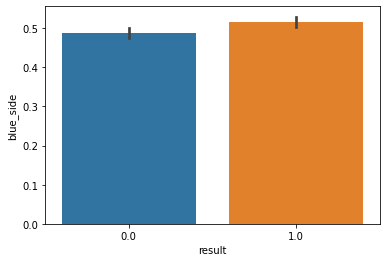

In [32]:
sns.barplot(data = full, x='result',y='blue_side')

In [33]:
len(df[(df.blue_side==1) & (df.result == 1)])/(df.shape[0]/2) #Establishes a baseline - blue team wins 52% of time

0.5191946766763351

In [34]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier

def create_objects():
    rr = RidgeClassifier(solver ='sag',normalize=False,)
    split = TimeSeriesSplit(n_splits=3)
    sfs = SequentialFeatureSelector(rr, n_features_to_select=14,direction='backward',cv=split,n_jobs=-1)

create_objects()

In [35]:
removed_columns = list(full.columns[full.dtypes=='object']) + removed_columns
selected_columns = full.columns[~full.columns.isin(removed_columns)]

In [ ]:
sfs.fit(full[selected_columns],full['target'])

In [ ]:
selectors = selected_columns[sfs.get_support()]

In [ ]:
predictions = backtest(full,rr,selectors,'target')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(predictions.actual,predictions.prediction)

.5665 'forward', rr

In [ ]:
def near_split(x, num_bins): #Split my df into equal splits to perform backtesting
    quotient, remainder = divmod(x, num_bins)
    bins = [quotient + 1] * remainder + [quotient] * (num_bins - remainder)
    count = 0
    new_list = []
    for b in bins:
        count += b
        new_list.append(count)
    return new_list

splits = near_split(df.shape[0],5)
last_split = splits[4]-splits[3] #Difference between last two values for final 'test' set

In [ ]:
def backtest(data,model,predictors,target):
    all_predictions= []
    
    for i in range(0,len(splits)-1):
        train = data.loc[:splits[i]]
        test = data.loc[splits[i]:splits[i]+last_split]
        
        model.fit(train[predictors],train[target])
        preds = model.predict(test[predictors])
        preds = pd.Series(preds,index=test.index)
        combined = pd.concat([test[target],preds],axis=1)
        combined.columns = ['actual','prediction']
        
        all_predictions.append(combined)
        
    return pd.concat(all_predictions)
        
        
        
        


In [ ]:
predictions = backtest(full,rr,selectors,'target')

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(predictions.actual,predictions.prediction)

### optimize ridge regression

In [ ]:
from sklearn import decomposition
from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

In [ ]:
X = full[selectors]
y = full['target']

In [ ]:
pca = decomposition.PCA()
ridge = linear_model.Ridge()

In [ ]:
pipe = Pipeline(steps=[("pca", pca),
                        ("ridge", ridge)])

In [ ]:
n_components = list(range(1,X.shape[1]+1,1))
normalize = [True, False]
solver = ["auto", "svd", "cholesky", "lsqr", "sparse_cg", "sag", "saga"]
parameters = dict(pca__n_components=n_components,
                      ridge__normalize=normalize,
                      ridge__solver=solver)

In [ ]:
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X, y)

In [ ]:
clf_GS.best_params_

In [ ]:
print("Best Number Of Components:", clf_GS.best_estimator_.get_params()["pca__n_components"])
print(); print(clf_GS.best_estimator_.get_params()["ridge"])



In [42]:
df.shape

(11722, 47)

In [44]:
df.tail()

,teamname,league,date,blue_side,gamelength,game,result,teamkills,teamdeaths,firstblood,dragons,barons,opp_barons,towers,opp_towers,inhibitors,opp_inhibitors,damagetochampions,damagetakenperminute,wardsplaced,wardskilled,controlwardsbought,totalgold,gspd,target,opp_name,gamelength_rolling,teamkills_rolling,teamdeaths_rolling,firstblood_rolling,dragons_rolling,barons_rolling,opp_barons_rolling,towers_rolling,opp_towers_rolling,inhibitors_rolling,opp_inhibitors_rolling,damagetochampions_rolling,damagetakenperminute_rolling,wardsplaced_rolling,wardskilled_rolling,controlwardsbought_rolling,totalgold_rolling,gspd_rolling,next_opp,next_blue,next_date
12857,DRX,LCK,2023-02-15 08:57:15,0.0,0.271558,0.25,0.0,0.179487,0.461538,0.0,0.166667,0.00,0.50,0.272727,1.000000,0.000000,0.428571,0.215048,0.470594,0.0,0.303371,0.404040,0.284052,0.335305,2,KT Rolster,0.241518,0.210256,0.348718,0.1,0.250000,0.075,0.225,0.300000,0.727273,0.071429,0.200000,0.208102,0.490160,0.238037,0.271348,0.372727,0.260766,0.388066,2,2,2
12858,Nongshim RedForce,LCK,2023-02-15 10:37:15,1.0,0.405143,0.00,0.0,0.282051,0.333333,0.0,0.166667,0.00,0.25,0.363636,1.000000,0.000000,0.428571,0.269260,0.506997,0.0,0.297753,0.606061,0.412882,0.407563,0,Hanwha Life Esports,0.262966,0.197436,0.325641,0.2,0.166667,0.075,0.225,0.272727,0.809091,0.028571,0.242857,0.180763,0.489022,0.258896,0.230337,0.388889,0.279500,0.392446,Hanwha Life Esports,1,2023-02-15 11:39:14
12859,Hanwha Life Esports,LCK,2023-02-15 10:37:15,0.0,0.405143,0.00,1.0,0.333333,0.282051,1.0,0.666667,0.25,0.00,1.000000,0.363636,0.428571,0.000000,0.355483,0.411752,0.0,0.460674,0.595960,0.509133,0.592437,1,Nongshim RedForce,0.308592,0.243590,0.217949,0.6,0.366667,0.200,0.200,0.590909,0.481818,0.171429,0.100000,0.247753,0.471949,0.324233,0.294382,0.409091,0.369562,0.537296,Nongshim RedForce,0,2023-02-15 11:39:14
12860,Nongshim RedForce,LCK,2023-02-15 11:39:14,1.0,0.333020,0.25,0.0,0.153846,0.333333,0.0,0.500000,0.25,0.00,0.090909,0.909091,0.000000,0.142857,0.228105,0.375239,0.0,0.308989,0.626263,0.332468,0.432481,2,Hanwha Life Esports,0.268799,0.207692,0.343590,0.2,0.200000,0.100,0.175,0.263636,0.800000,0.028571,0.214286,0.192262,0.486717,0.230061,0.236517,0.413131,0.285761,0.396095,2,2,2
12861,Hanwha Life Esports,LCK,2023-02-15 11:39:14,0.0,0.333020,0.25,1.0,0.333333,0.153846,1.0,0.333333,0.00,0.25,0.909091,0.090909,0.142857,0.000000,0.267787,0.429495,0.0,0.550562,0.434343,0.439794,0.567519,2,Nongshim RedForce,0.321511,0.248718,0.228205,0.7,0.333333,0.175,0.225,0.600000,0.481818,0.157143,0.100000,0.255804,0.473826,0.293865,0.331461,0.418182,0.381713,0.529285,2,2,2
